In [2]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False) #This is for the 1/8 degree case


# #1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages

# #1/8 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

# #1/16 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('sub01/ocean.stats.nc', decode_times=False)
#os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                        'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00000902.nc', decode_times=False)  #20 5-day averages
#av = xr.open_mfdataset(['averages_00000502.nc','averages_00000602.nc','averages_00000702.nc','averages_00000802.nc','averages_00000902.nc'], decode_times=False)  #20 5-day averages
%ls
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/scratch/gmarques/NW2_TMP/nw2_0.03125deg_N15_baseline_hmix5
available_diags.000000  longmean_00000850.nc         sub01/
averages_00000402.nc    longmean_00000950.nc         sub02/
averages_00000502.nc    MOM_IC_1.nc                  sub03/
averages_00000602.nc    MOM_IC_2.nc                  sub04/
averages_00000702.nc    MOM_IC.nc                    sub04_sfc/
averages_00000802.nc    MOM_input@                   sub05/
averages_00000902.nc    MOM_layout@                  sub05_sfc/
CPU_stats               MOM_override                 sub06/
diag_table@             MOM_parameter_doc.all        sub06_sfc/
diag_table.final        MOM_parameter_doc.debugging  sub07/
diag_table.init         MOM_parameter_doc.layout     sub07_sfc/
diag_table.sfc          MOM_parameter_doc.short      sub08/
exitcode                ocean_geometry.nc            sub08_sfc/
INPUT/                  README                       submit_cheyenne
input.nml  

In [4]:
lat= (av.yh)     
lon= (av.xh)     

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))
Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
Ld = av.Rd1[:].mean('time')

(20, 4480, 1920) (20, 4480, 1920)


In [5]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/32,'km')
print('max dx:',2*np.pi*6378000/360/32,'km')

min dx: 1189.7715747288576 km
max dx: 3478.6593653811983 km


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


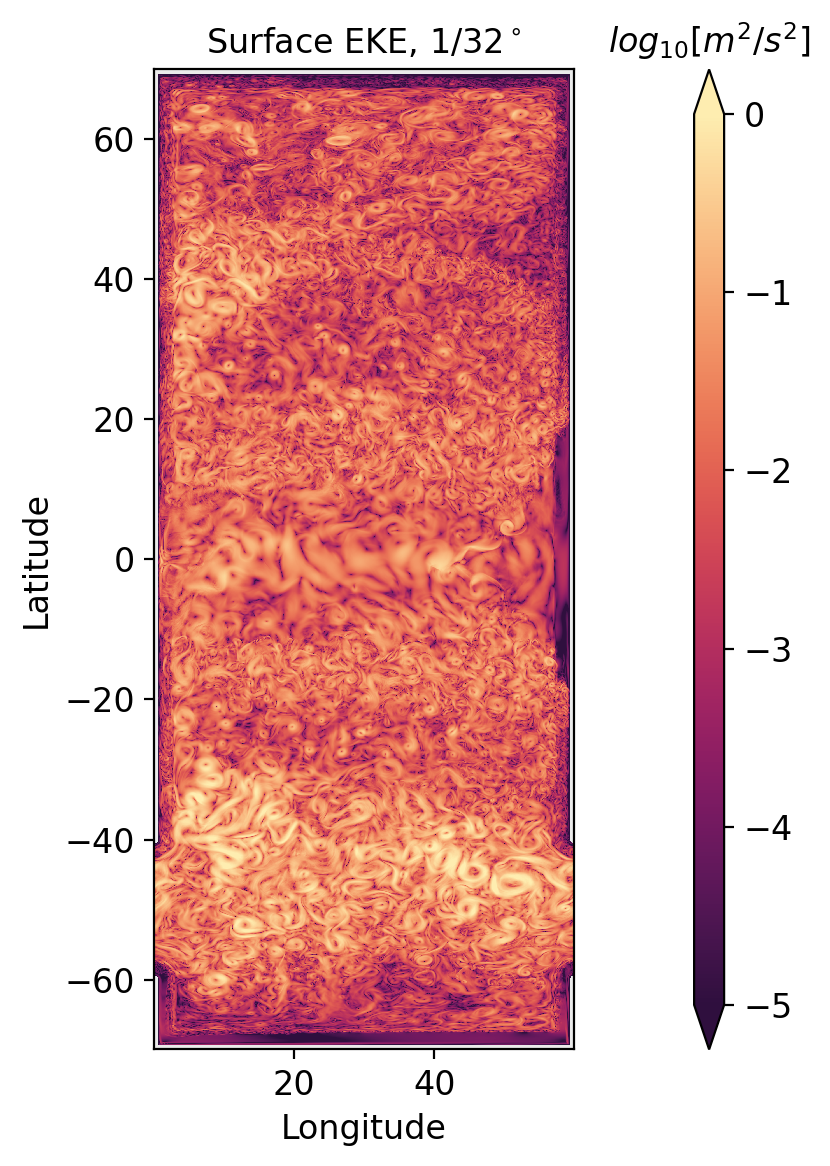

In [6]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)


ax1.set_title('Surface EKE, 1/32$^\circ$',fontsize=12)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon[:],lat[:],np.log10(KE[-1,:,:]),cmap=cmocean.cm.matter_r,vmin=-5,vmax=0)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical',extend='both');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$log_{10}[m^2/s^2]$')
#
plt.show()

(4480, 1920)


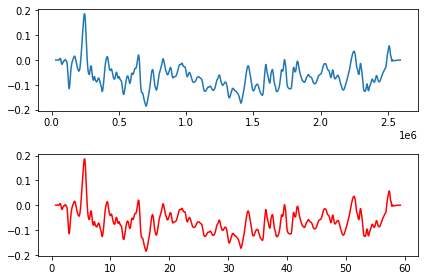

In [7]:
xi=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.
#xi=(xi-xi[:,479]) #Center the grid along the center longitude.


index=100
xline= xi[index,:]
uline= u[:,index,:]; uline=uline.assign_coords(xh=xline)
vline= v[:,index,:]; vline=uline.assign_coords(xh=xline)

print(xi.shape)

fig, ax = plt.subplots(2)
ax[0].plot(uline.xh,uline[0,:])
ax[1].plot(u[0,index,:].xh,u[0,index,:],'r')
plt.tight_layout()

### Computing the 1D spectrum at one latitude

In [8]:
time=np.arange(0,1,1)

boundary=50 #50
for i in range(75,76):#,len(lat)):

    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary].fillna(0.); uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary].fillna(0.); vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute() #, window='hann/hamming', detrend='linear'
    viso2 = xrft.power_spectrum(vline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute()
    ekeiso = .5*(uiso2 + viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.
    #ekeiso = .5*(viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.

    nk = int(len(ekeiso)/2.)

    ekeiso=ekeiso[nk+1:]    # half of the latitude array size
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    LD_wavenumber=(1/(Ldline/1000)).mean('xh')
    ES_wavenumber=ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
  
    alt_PS=0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
    #alt_PS=0.5*(np.abs(np.fft.rfft(uline))**2)+0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
    #alt_PS=alt_PS/(int(len(xline))**2)       #if using scaling spectrum, preserves units m2/s2 (my interpretation)
    alt_PS=alt_PS*np.array(dx[i,100]/len(xline)) #if using scaling density, units m3/s2
    alt_freq= np.fft.rfftfreq(uline.size,np.array(dx[i,100])/(1000*2*np.pi))
    
    centroid = np.nansum(ekeiso*wavenumber)/np.nansum(ekeiso)
    

In [9]:
wavenumber.shape

(909,)

In [10]:
xline

<xarray.DataArray (xh: 1820)>
array([  66166.66498644,   67489.99828617,   68813.3315859 , ...,
       2470663.27059362, 2471986.60389335, 2473309.93719308])
Coordinates:
    yh       float64 -67.64
  * xh       (xh) float64 1.578 1.609 1.641 1.672 ... 58.33 58.36 58.39 58.42

In [11]:
lat[index]

<xarray.DataArray 'yh' ()>
array(-66.859375)
Coordinates:
    yh       float64 -66.86
Attributes:
    long_name:       h point nominal latitude
    units:           degrees_north
    cartesian_axis:  Y

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

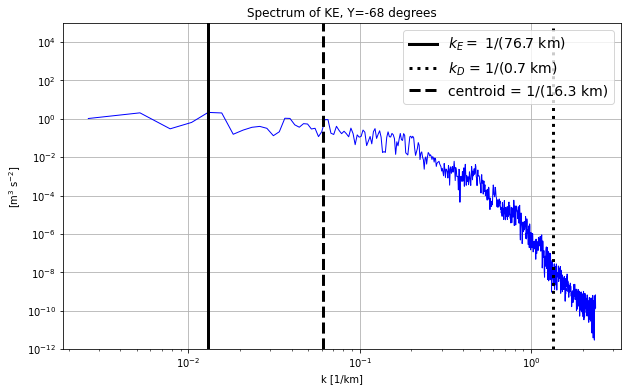

In [12]:
fig, ax = plt.subplots(figsize=(10,6))


#plt.plot(alt_freq[1:],alt_PS[0,1:],'-*r',linewidth=4)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber,ekeiso,'-b',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

l1=plt.plot([ES_wavenumber,ES_wavenumber], [1e-12,1e5],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/ES_wavenumber))
l2=plt.plot([LD_wavenumber,LD_wavenumber], [1e-12,1e5],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
l2=plt.plot([centroid,centroid], [1e-12,1e5],'--k',linewidth=3,label='centroid = 1/(%.1f km)'%(1/centroid))

plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f degrees'%lat[i])
plt.ylim([1e-12, 1e5])
#plt.xlim([1e-4, 1e1])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

### Computing the 1D spectrum at each latitude for all times:

In [13]:
time=np.arange(0,20,1)

lim = 80 #40 for HR
LD_wavenumber=Ld[lim:-lim,0]*0.0
ES_wavenumber=Ld[lim:-lim,0]*0.0
ES_stdev     =Ld[lim:-lim,0]*0.0

centroid      =Ld[lim:-lim,0]*0.0
centroid_stdev=Ld[lim:-lim,0]*0.0

boundary=lim
for i in range(lim,len(lat)-lim):#,len(lat)):

    #nantester= u[0,i,:]; 
    #nantester=(~np.isnan(nantester)); res = [i for i, val in enumerate(nantester) if val]
    #print(min(res),max(res));
    #lon1= min(res)+20
    #lon2= max(res)-20
    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary]; uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary]; vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'],scaling="density").compute() #generally don't want window and detrending when using the centroid, they change shape.
    viso2 = xrft.power_spectrum(vline,dim=['xh'],scaling="density").compute()
    #ekeiso = .5*(uiso2 + viso2)
    ekeiso = .5*(viso2)

    nk = int(len(ekeiso[1])/2.)
    ekeiso=ekeiso[:,nk+1:]    #460 in length, half of the used longitude array (20-940)
    
    ES_stdev[i-lim]     =(1./(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi)).std('time').values
    ES_wavenumber[i-lim]=(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi).mean('time').values #don't count first 3 wavenumbers, compute most energetic wavenumber then average over time
    LD_wavenumber[i-lim]=(1/(Ldline/1000)).mean('xh').values
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    
    centroid[i-lim] = ((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh')).mean('time')
    centroid_stdev[i-lim]=(1/((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh'))).std('time')
    ekeiso=ekeiso.mean('time')
    #ES_wavenumber[i-lim]=(ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi)
    print(i)
    
    
    #ES_wavenumber=ekeiso.idxmax(dim='freq_xh')*1000*2*np.pi 

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334


In [11]:
ES_stdev

<xarray.DataArray 'Rd1' (yh: 4320)>
array([3.7990189, 1.5659775, 1.6943495, ..., 3.9912016, 4.790097 ,
       4.5495734], dtype=float32)
Coordinates:
  * yh       (yh) float64 -67.48 -67.45 -67.42 -67.39 ... 67.42 67.45 67.48
    xh       float64 0.01562

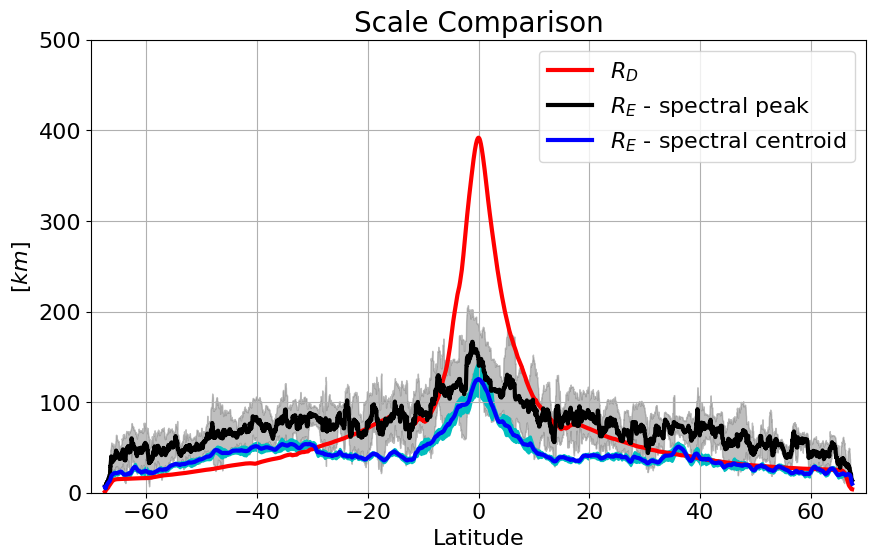

In [14]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)


plt.plot(LD_wavenumber.yh,1./LD_wavenumber,'-',c='r',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,1./ES_wavenumber,'-',c='k',linewidth=3,label='$R_E$ - spectral peak')
plt.fill_between(ES_wavenumber.yh, 1./(ES_wavenumber)+ES_stdev, 1./(ES_wavenumber)-ES_stdev,color=(0.5,0.5,0.5,0.5))

plt.plot(centroid.yh,1./centroid,'-',c='b',linewidth=3,label='$R_E$ - spectral centroid')
plt.fill_between(centroid.yh, 1./(centroid)+centroid_stdev, 1./(centroid)-centroid_stdev,color='c')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 500]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

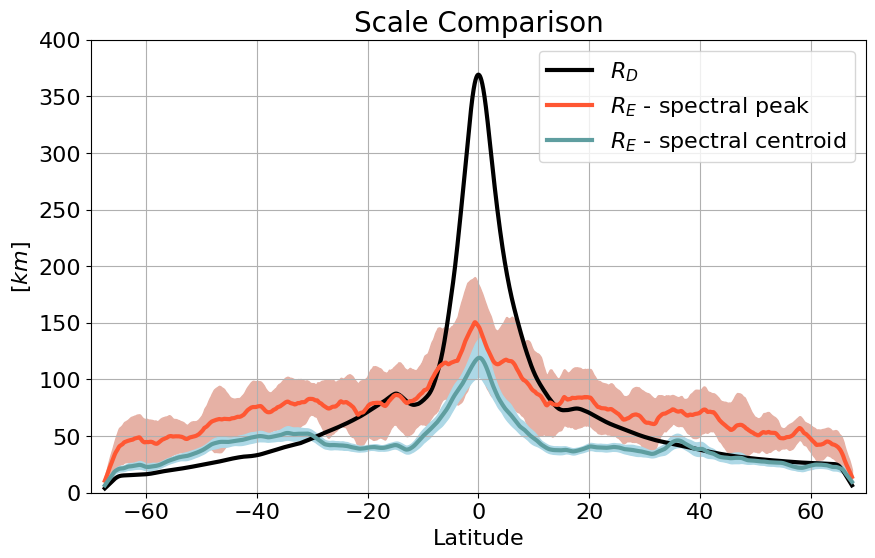

In [15]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)

window=100
smooth_ES=np.convolve(1./ES_wavenumber, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_ES_stdev     =np.convolve(ES_stdev, np.ones((window,))/window, mode='same')

smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_centroid_stdev=np.convolve(centroid_stdev, np.ones((window,))/window, mode='same')



plt.plot(LD_wavenumber.yh,smooth_LD,'-',c='k',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,smooth_ES,'-',c='#FF5733',linewidth=3,label='$R_E$ - spectral peak')
plt.fill_between(ES_wavenumber.yh, smooth_ES+smooth_ES_stdev, smooth_ES-smooth_ES_stdev,color='#e6b1a5')

plt.plot(centroid.yh,smooth_centroid,'-',c='#5F9EA0',linewidth=3,label='$R_E$ - spectral centroid')
plt.fill_between(centroid.yh, smooth_centroid+smooth_centroid_stdev, smooth_centroid-smooth_centroid_stdev,color='#ADD8E6')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 400]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

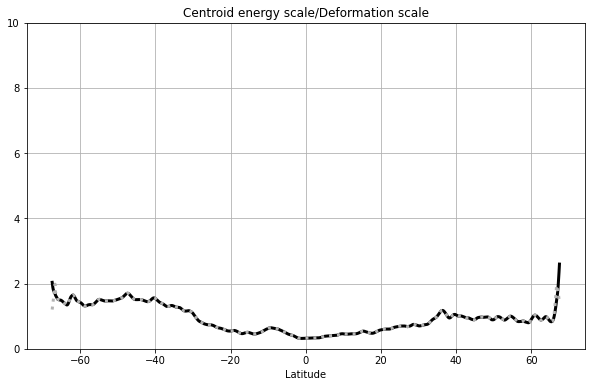

In [16]:
fig, ax = plt.subplots(figsize=(10,6))


 
window=50
smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_centroid_LD=np.convolve(LD_wavenumber/centroid, np.ones((window,))/window, mode='same')

#plt.plot(ES_wavenumber.yh,c,'-',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,(smooth_centroid/smooth_LD),'-',c='k',linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,smooth_centroid_LD,':',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')


plt.title('Centroid energy scale/Deformation scale')
plt.ylim([0, 10])
#plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('Latitude'); 
#plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [17]:
#COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)


In [18]:
Depth.shape

(4480, 1920)

In [19]:
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x
print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')

print('done 2')
# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_mean_BC

done 1
done 2


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '1/32$^\\circ$ BT,BC EKE fractions')

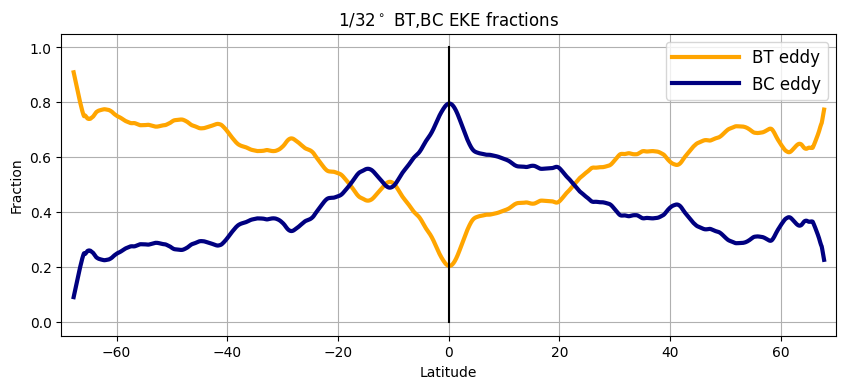

In [20]:
window=100

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BT/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c='#ffa500',linewidth=3)

plt.grid()
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BC/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c=[0,0,.5],linewidth=3)


plt.legend(['BT eddy','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70)
#plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/32$^\circ$ BT,BC EKE fractions')

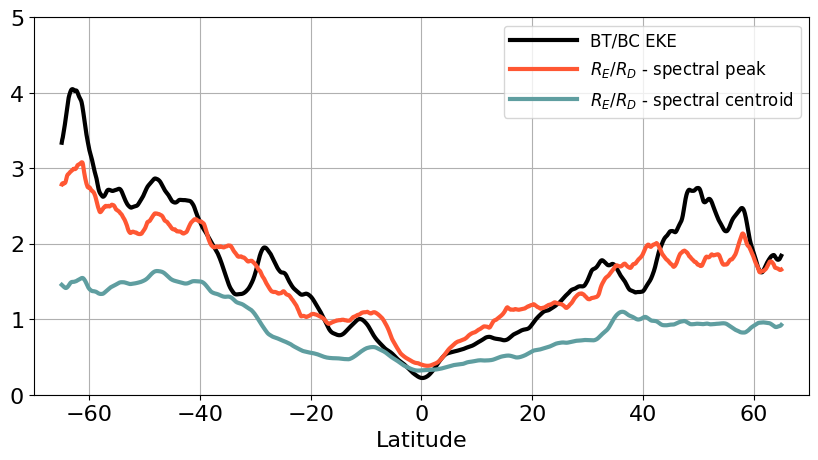

In [21]:
window=100

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];

BT_BC=np.convolve((Eddy_BT/Eddy_BC), np.ones((window,))/window, mode='same')
LES_LD=np.convolve((LD_wavenumber/ES_wavenumber), np.ones((window,))/window, mode='same')
LEC_LD=np.convolve((LD_wavenumber/centroid), np.ones((window,))/window, mode='same')

bound1=80; bound2=-80
plt.plot(yh_center[bound1:bound2],BT_BC[bound1:bound2],'-',c='k',linewidth=3)

plt.plot(yh_center[bound1:bound2],LES_LD[bound1:bound2],'-',c='#FF5733',linewidth=3)
plt.plot(yh_center[bound1:bound2],LEC_LD[bound1:bound2],'-',c='#5F9EA0',linewidth=3)


plt.legend(['BT/BC EKE','$R_E/R_D$ - spectral peak','$R_E/R_D$ - spectral centroid'],loc='upper right',fontsize=12,handlelength=4)
#plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.ylim([0, 5]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
#plt.ylabel('Fraction')
#plt.title('1/32$^\circ$')
plt.grid()

In [22]:
plt.rcParams.update({'font.size': 12})

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


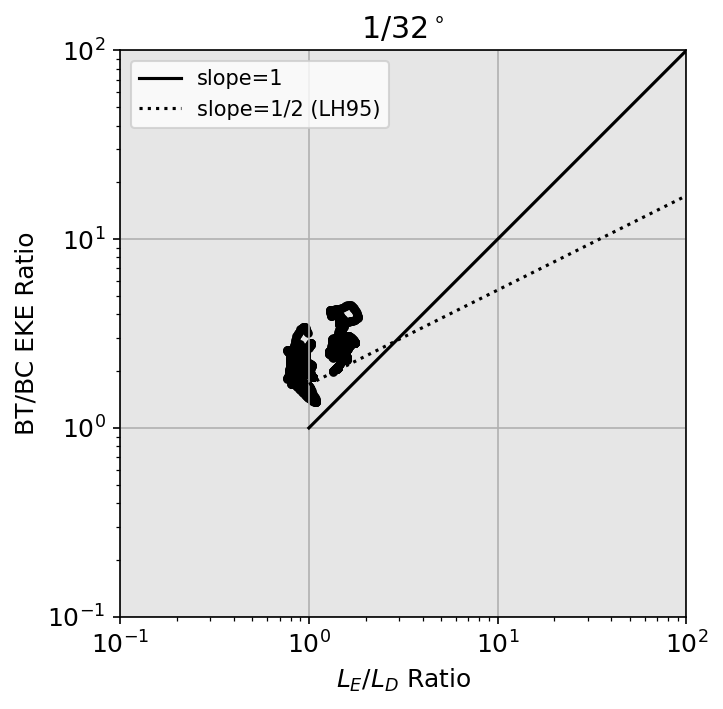

In [23]:

plt.figure(figsize=(10, 5), dpi= 150, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];
BT_BC=(Eddy_BT/Eddy_BC)
LE_LD=(LD_wavenumber/centroid)

bound1=80; bound2=-80
plt.scatter(LE_LD[bound1:960],BT_BC[bound1:960],c='k',s=10)#, cmap='RdYlBu')
plt.scatter(LE_LD[-600:bound2],BT_BC[-600:bound2],c='k',s=10)#, cmap='RdYlBu')


#plt.xlim(0,5)
#plt.ylim(0,5);
plt.ylim([1e-1, 1e2])
plt.xlim([1e-1, 1e2])
plt.xscale('log')
plt.yscale('log')

#plt.plot([1e0,1e2],[1e0,1e1],':k',linewidth=2)
plt.ylabel('BT/BC EKE Ratio')
plt.xlabel('$L_E/L_D$ Ratio')
plt.title('1/32$^\circ$')
plt.grid()
#clb=plt.colorbar()
#clb.ax.set_title('Lat.',fontsize=12)


coefficients = np.polyfit(np.log10(LE_LD[bound1:bound2]), np.log10(BT_BC[bound1:bound2]), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(LE_LD[bound1:bound2])) 
#
#plt.plot(LE_LD[bound1:bound2], 10**log10_y_fit, 'k-',label='regression slope %.4f'% (polynomial[1]))  
plt.plot([1,100], [1,100], 'k-',label='slope=1')  
plt.plot([1,100], [1*1.7,10*1.7], 'k:',label='slope=1/2 (LH95)') 
plt.legend(fontsize=10)
ax = plt.axes()
ax.set_facecolor([0.9,0.9,0.9])
plt.gca().set_aspect('equal')

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


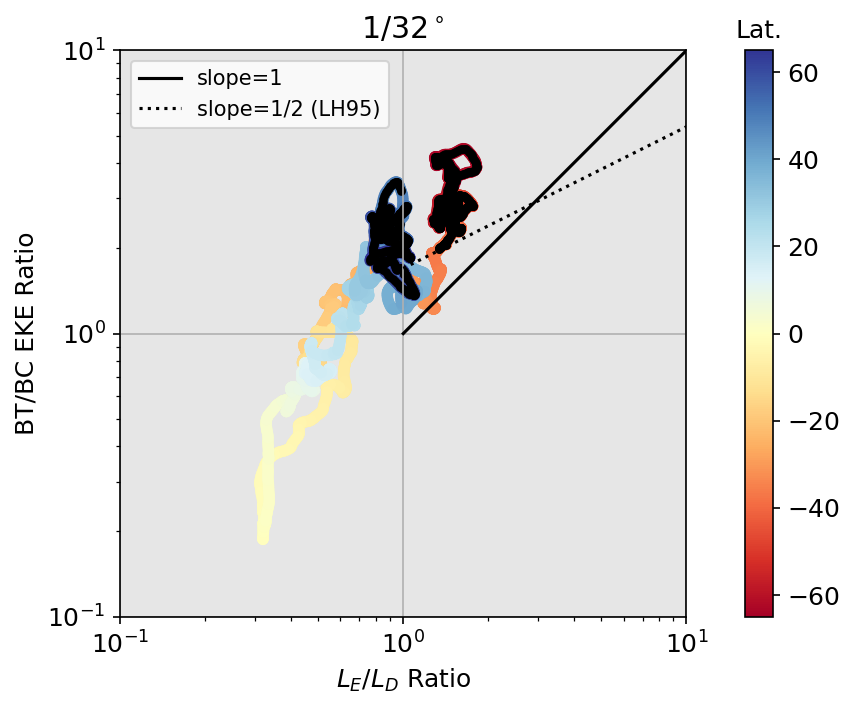

In [25]:

plt.figure(figsize=(10, 5), dpi= 150, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];
BT_BC=(Eddy_BT/Eddy_BC)
LE_LD=(LD_wavenumber/centroid)

bound1=80; bound2=-80
plt.scatter(LE_LD[bound1:bound2],BT_BC[bound1:bound2],c=yh_center[bound1:bound2], cmap='RdYlBu',marker='o',s=20)


#plt.xlim(0,5)
#plt.ylim(0,5);
plt.ylim([1e-1, 1e1])
plt.xlim([1e-1, 1e1])
plt.xscale('log')
plt.yscale('log')

#plt.plot([1e0,1e2],[1e0,1e1],':k',linewidth=2)
plt.ylabel('BT/BC EKE Ratio')
plt.xlabel('$L_E/L_D$ Ratio')
plt.title('1/32$^\circ$')
plt.grid()
clb=plt.colorbar()
clb.ax.set_title('Lat.',fontsize=12)


coefficients = np.polyfit(np.log10(LE_LD[bound1:bound2]), np.log10(BT_BC[bound1:bound2]), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(LE_LD[bound1:bound2])) 
#
#plt.plot(LE_LD[bound1:bound2], 10**log10_y_fit, 'k-',label='regression slope %.4f'% (polynomial[1]))  
plt.plot([1,100], [1,100], 'k-',label='slope=1')  
plt.plot([1,100], [1*1.7,10*1.7], 'k:',label='slope=1/2 (LH95)') 
plt.legend(fontsize=10)
ax = plt.axes()
ax.set_facecolor([0.9,0.9,0.9])
plt.gca().set_aspect('equal')

plt.scatter(LE_LD[bound1:960],BT_BC[bound1:960],c='k',s=10)#, cmap='RdYlBu')
plt.scatter(LE_LD[-600:bound2],BT_BC[-600:bound2],c='k',s=10)#, cmap='RdYlBu')